In [8]:
# import all required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

seed = 7
scoring = 'neg_mean_squared_error'

In [9]:
pisa = pd.read_csv('pisa2009.csv')
y = pisa['readingScore']
pisa = pisa.drop('readingScore', axis=1)

# Missing values
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisa = pisa.apply(lambda x:x.fillna(0.5))

# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

# remove multicolinearity
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

X = pisa.values


In [10]:
from sklearn.model_selection import ShuffleSplit, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



In [13]:

model = GradientBoostingRegressor(n_estimators=200)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

# base line scores
baseline_pred = np.empty(y_test.shape[0])
baseline_pred.fill(np.mean(y_test))

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
print('test set rmse: %.2f is better compared to baseline %.2f' % (rmse, baseline_rmse))
print('test set r2: %.2f is better than baseline %.2f' % (r2, baseline_r2))

test set rmse: 71.78 is better compared to baseline 94.41
test set r2: 0.42 is better than baseline 0.00


In [5]:
# Based on visualization library provided with Proj-2 of Machine Learning Nano Degree
import matplotlib.pyplot as plt
import sklearn.model_selection as curves
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split
%matplotlib inline
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
    # Create the figure window
    fig = plt.figure(figsize=(10,7))
    # Create three different models based on max_depth
    for k, estimators in enumerate([50,100,150,200,250,300,350,400]):
       
        # Create a Decision tree regressor at max_depth = depth
        regressor = GradientBoostingRegressor(n_estimators = estimators)
        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
     
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        #ax = fig.add_subplot(2, 2, k+1)
        ax = fig.add_subplot(4, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('n_estimators = %s'%(estimators))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('R2 Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Gradient Boosting Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the n_estimators parameter from 1 to 10
    n_estimators = np.array([50,100,150,200,250,300,350,400])

    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(GradientBoostingRegressor(), X, y, \
        param_name = "n_estimators", param_range = n_estimators, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Gradient Boosting Regressor Complexity Performance')
    plt.plot(n_estimators, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(n_estimators, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(n_estimators, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(n_estimators, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('n_estimators')
    plt.ylabel('R2 Score')
    plt.ylim([-0.05,1.05])
    plt.show()

C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


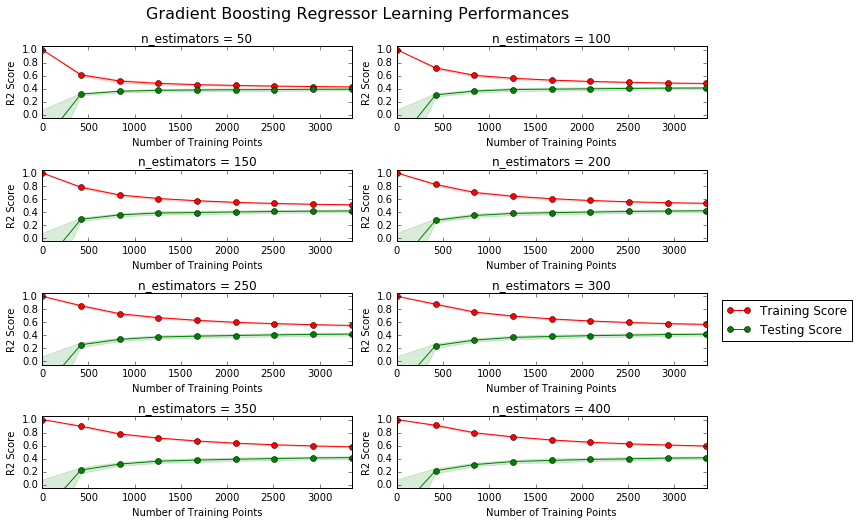

In [6]:
ModelLearning(X_train, y_train)

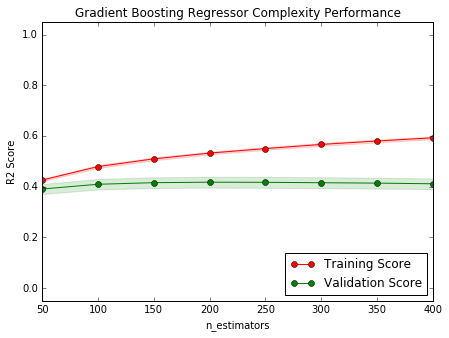

In [7]:
ModelComplexity(X_train, y_train)